In [2]:
import os
import pandas as pd 
import numpy as np

import tensorflow 
from tensorflow import keras
from keras import layers, regularizers

import cv2 #images

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## import dependencies for model
%matplotlib inline
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical, normalize
from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy

from sklearn.metrics import classification_report, confusion_matrix

2024-10-18 09:24:17.782603: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
import json

with open('config.json', 'r') as config_file:
    config = json.load(config_file)

DB_HOST = config["DB_HOST"]
DB_NAME = config["DB_NAME"]
DB_USER = config["DB_USER"]
DB_PASS = config["DB_PASS"]


In [6]:
# Define paths for the dataset directories
benign_dir = 'train_cancer/benign'
malignant_dir = 'train_cancer/malignant'

In [7]:
# Collect image paths and labels into a list
data = []
for category, folder in [('benign', benign_dir), ('malignant', malignant_dir)]:
    for filename in os.listdir(folder):
        if filename.endswith('.jpg'):
            file_path = os.path.join(folder, filename)
            data.append({'file_path': file_path, 'label': category})


In [8]:
# Create a DataFrame from the collected data
df = pd.DataFrame(data)

# Display the first few rows of the DataFrame
print(df.head())

                    file_path   label
0  train_cancer/benign/14.jpg  benign
1  train_cancer/benign/28.jpg  benign
2  train_cancer/benign/29.jpg  benign
3  train_cancer/benign/17.jpg  benign
4  train_cancer/benign/12.jpg  benign


In [9]:
import cv2

# Function to read image as binary data
def read_image_binary(file_path):
    with open(file_path, 'rb') as file:
        return file.read()

# Add binary image data as a new column in the DataFrame
df['image_data'] = df['file_path'].apply(read_image_binary)

# Display the first few rows of the DataFrame
print(df.head())


                    file_path   label  \
0  train_cancer/benign/14.jpg  benign   
1  train_cancer/benign/28.jpg  benign   
2  train_cancer/benign/29.jpg  benign   
3  train_cancer/benign/17.jpg  benign   
4  train_cancer/benign/12.jpg  benign   

                                          image_data  
0  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...  
1  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...  
2  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...  
3  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...  
4  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...  


In [1]:
import psycopg2
import json

with open('config.json', 'r') as config_file:
    config = json.load(config_file)

DB_HOST = config["DB_HOST"]
DB_NAME = config["DB_NAME"]
DB_USER = config["DB_USER"]
DB_PASS = config["DB_PASS"]


try:
    # Connect to the database
    connection = psycopg2.connect(
        host=DB_HOST,
        database=DB_NAME,
        user=DB_USER,
        password=DB_PASS
    )
    cursor = connection.cursor()

    # Create the table if it does not exist
    create_table_query = """
    CREATE TABLE IF NOT EXISTS skin_cancer_images (
        id SERIAL PRIMARY KEY,
        label TEXT,
        image_data BYTEA
    );
    """
    cursor.execute(create_table_query)
    connection.commit()
    print("Table 'skin_cancer_images' created successfully.")

except Exception as e:
    print(f"An error occurred while creating the table: {e}")

finally:
    if 'cursor' in locals():
        cursor.close()
    if 'connection' in locals():
        connection.close()


Table 'skin_cancer_images' created successfully.


In [10]:
try:
    # Connect to the database
    connection = psycopg2.connect(
        host=DB_HOST,
        database=DB_NAME,
        user=DB_USER,
        password=DB_PASS
    )
    cursor = connection.cursor()

    # Iterate over the DataFrame rows and insert each record into the table
    for index, row in df.iterrows():
        insert_query = """
        INSERT INTO skin_cancer_images (label, image_data) VALUES (%s, %s);
        """
        cursor.execute(insert_query, (row['label'], psycopg2.Binary(row['image_data'])))

    # Commit the transaction
    connection.commit()
    print("Data inserted successfully.")

except Exception as e:
    print(f"An error occurred while inserting data: {e}")

finally:
    if 'cursor' in locals():
        cursor.close()
    if 'connection' in locals():
        connection.close()


Data inserted successfully.


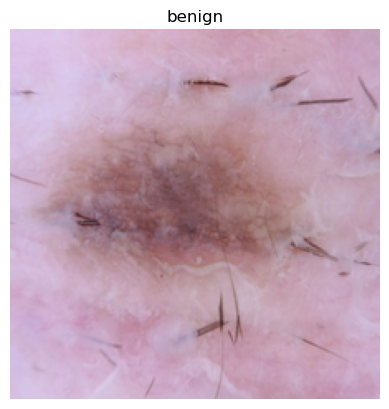

In [11]:
try:
    # Connect to the database
    connection = psycopg2.connect(
        host=DB_HOST,
        database=DB_NAME,
        user=DB_USER,
        password=DB_PASS
    )
    cursor = connection.cursor()

    # Query to select the first image record
    cursor.execute("SELECT label, image_data FROM skin_cancer_images LIMIT 1;")
    row = cursor.fetchone()

    if row:
        label, image_data = row
        # Convert binary data back into an image and display it
        from PIL import Image
        import io
        import matplotlib.pyplot as plt

        image = Image.open(io.BytesIO(image_data))
        plt.imshow(image)
        plt.title(label)
        plt.axis('off')
        plt.show()
    else:
        print("No data found in the table.")

except Exception as e:
    print(f"An error occurred while retrieving images: {e}")

finally:
    if 'cursor' in locals():
        cursor.close()
    if 'connection' in locals():
        connection.close()


In [21]:
# Export the DataFrame to a CSV file
df.to_csv('output.csv', index=False)

In [23]:
df = pd.read_csv('path_to_dataset.csv')
x = df.drop('label',axis=1)
y = df['label']
x = x.to_numpy()
x = x/255
y = to_categorical(y)

FileNotFoundError: [Errno 2] No such file or directory: 'path_to_dataset.csv'

In [ ]:
# Images 

In [ ]:
# load images in 
def load_images(image_paths):
    images = []
    for path in image_paths:
        img = cv2.imread(path)
        img = cv2.resize(img, (224, 224)) 
        images.append(img)
    return np.array(images)

# Assuming you have a column with image paths
images = load_images(df['image_path'].values)
labels = df['label'].values 

In [ ]:
# Split the DataSet

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.05, random_state=42)

In [ ]:
# Build CNN (conv neural network) Model 

In [ ]:
def build_cnn_model(input_shape=(224, 224, 3), num_classes=1000):
    model = models.Sequential()
    
    # Block 1
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=input_shape))
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))
    model.add(BatchNormalization())

    # Block 2
    model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))
    model.add(BatchNormalization())

    # Block 3
    model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))
    model.add(BatchNormalization())

    # Block 4
    model.add(layers.Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(layers.Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(layers.Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))
    model.add(BatchNormalization())

    # Block 5
    model.add(layers.Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(layers.Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(layers.Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))
    model.add(BatchNormalization())

    # Flatten and Fully Connected Layers
    model.add(layers.Flatten())
    model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.Dense(num_classes, activation='softmax'))
    
    return model









In [ ]:
model.compile(optimizer='adam',loss= 'categorical_crossentropy', metrics= ['accuracy'])


In [ ]:
model.summary()

In [ ]:
#Training our CNN Model
class_weights = {0:1,1:0.5,2:1,3:1,4:1,5:1,6:1}
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=90, class_weight=class_weights,validation_data=(y_train, y_test))

In [ ]:
#Evaluate the Model 
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc}')

In [ ]:
# Make Predictions
predictions=model.predict_classes(y_train)

check=[]
for i in range(len(y_test)):
  for j in range(7):
    if(y_test[i][j]==1):
      check.append(j)
check=np.asarray(check)

print(classification_report(check, predictions))

In [ ]:
# model.save('modelv1.h5')

In [ ]:
# Check accuracy
from sklearn.metrics import accuracy_score
y_pred = log_classifier.predict(X_test)
print(f" Logistic regression model accuracy: {accuracy_score(y_test,y_pred):.3f}")